# 随机森林回归来推荐区间（使用多个特征）

=== 基于随机森林的子电池宽度区间推荐 ===
📊 正在加载数据...
原始数据形状: (34, 31)

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Active_Area                    34 non-null     float64
 1   P1Wavelength(nm)               34 non-null     int64  
 2   P2Wavelength(nm)               34 non-null     int64  
 3   P3Wavelength(nm)               34 non-null     int64  
 4   total_scribing_line_width(μm)  34 non-null     float64
 5   P1Width(μm)                    34 non-null     float64
 6   P2Width(μm)                    34 non-null     float64
 7   P3Width(μm)                    34 non-null     float64
 8   GFF                            34 non-null     float64
 9   Type                           34 non-null     int64  
 10  submodule_number               34 non-null     int64  
 11  P1Scan_Velocity(mm/s)          34 non-null     in

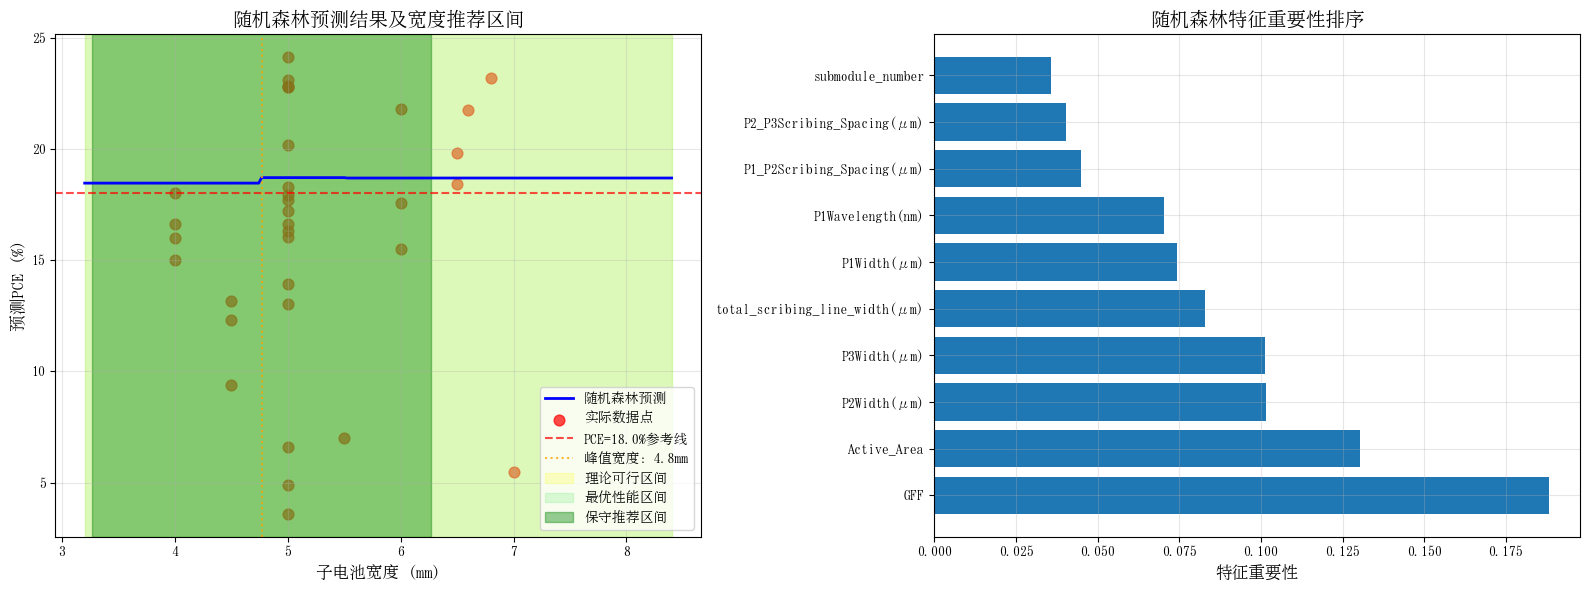


🎯 随机森林推荐结果摘要

📊 数据概况:
   总样本数: 34
   实际PCE范围: 3.6 - 24.1%
   实际宽度范围: 4.0 - 7.0 mm

🔮 模型预测:
   预测最高PCE: 18.70%
   预测最优宽度: 4.77 mm

📏 推荐区间:
   🟡 理论可行区间: 3.2 - 8.4 mm
   🟢 最优性能区间: 3.2 - 8.4 mm
   ✅ 保守推荐区间: 3.3 - 6.3 mm

💡 设计建议:
   建议优先考虑: 3.3-6.3 mm
   重点关注: 4.8 mm 附近的配置

📈 验证信息:
   保守区间内实际数据点: 29 个
   区间内平均实际PCE: 15.87%
   ⚠️  区间验证: 实际表现一般，建议结合工程经验

✅ 分析完成！结果已保存至 'random_forest_width_recommendation.png'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimSong', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_and_prepare_data(file_path):
    """
    加载和预处理数据
    """
    print("📊 正在加载数据...")
    df = pd.read_excel(file_path)
    print(f"原始数据形状: {df.shape}")
    
    # 显示数据基本信息
    print("\n数据基本信息:")
    print(df.info())
    
    # 检查目标变量和关键特征
    if 'PCE' not in df.columns:
        raise ValueError("数据中必须包含 'PCE' 列")
    
    if 'subcell_width(mm)' not in df.columns:
        raise ValueError("数据中必须包含 'subcell_width(mm)' 列")
    
    # 数据清洗
    df_clean = df.copy()
    
    # 处理缺失值
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['PCE', 'subcell_width(mm)'])
    print(f"去除缺失值后数据: {len(df_clean)} 行 (去除 {initial_count - len(df_clean)} 行)")
    
    # 过滤无效值
    df_clean = df_clean[df_clean['subcell_width(mm)'] > 0]
    print(f"过滤无效宽度后数据: {len(df_clean)} 行")
    
    # 选择数值型特征
    numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    
    # 移除目标变量和宽度特征（宽度特征将单独处理）
    if 'PCE' in numeric_features:
        numeric_features.remove('PCE')
    if 'subcell_width(mm)' in numeric_features:
        numeric_features.remove('subcell_width(mm)')
    
    print(f"\n可用的数值特征 ({len(numeric_features)} 个):")
    print(numeric_features)
    
    return df_clean, numeric_features

def prepare_features(df, numeric_features):
    """
    准备特征数据
    """
    # 构建特征矩阵
    feature_columns = ['subcell_width(mm)'] + numeric_features
    X = df[feature_columns]
    y = df['PCE']
    
    print(f"\n特征矩阵形状: {X.shape}")
    print(f"目标变量统计: 均值={y.mean():.2f}, 标准差={y.std():.2f}")
    print(f"子电池宽度范围: {X['subcell_width(mm)'].min():.1f}-{X['subcell_width(mm)'].max():.1f} mm")
    
    return X, y, feature_columns

def train_random_forest(X, y, feature_names):
    """
    训练随机森林模型并进行评估
    """
    print("\n🎯 训练随机森林模型...")
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 划分训练测试集（小样本情况下使用较大测试集比例）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )
    
    print(f"训练集: {X_train.shape[0]} 个样本")
    print(f"测试集: {X_test.shape[0]} 个样本")
    
    # 定义随机森林模型（针对小样本优化参数）
    rf_model = RandomForestRegressor(
        n_estimators=150,           # 增加树的数量以提高稳定性
        max_depth=6,                # 限制深度防止过拟合
        min_samples_split=5,        # 增加最小分割样本数
        min_samples_leaf=3,         # 增加叶节点最小样本数
        max_features='sqrt',        # 限制每棵树使用的特征数
        random_state=42,
        n_jobs=-1
    )
    
    # 训练模型
    rf_model.fit(X_train, y_train)
    
    # 预测
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # 评估模型
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print("\n📊 模型性能评估:")
    print(f"训练集 MAE: {train_mae:.3f}, R²: {train_r2:.3f}")
    print(f"测试集 MAE: {test_mae:.3f}, R²: {test_r2:.3f}")
    
    # 交叉验证
    if len(X) >= 10:
        cv_scores = cross_val_score(rf_model, X_scaled, y, cv=min(5, len(X)), 
                                  scoring='neg_mean_absolute_error')
        cv_mae = -cv_scores.mean()
        cv_std = cv_scores.std()
        print(f"交叉验证 MAE: {cv_mae:.3f} ± {cv_std:.3f}")
    
    # 特征重要性
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🔍 特征重要性排序:")
    for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
        print(f"  {i:2d}. {row['feature']:20} : {row['importance']:.4f}")
    
    return rf_model, scaler, feature_importance

def predict_optimal_width_range(rf_model, scaler, X, y, feature_names):
    """
    使用训练好的模型预测最优宽度区间
    """
    print("\n🔮 预测最优子电池宽度区间...")
    
    # 找到subcell_width在特征中的位置
    width_idx = feature_names.index('subcell_width(mm)')
    
    # 生成测试数据：固定其他特征，变化subcell_width
    width_range = np.linspace(
        X['subcell_width(mm)'].min() * 0.8, 
        X['subcell_width(mm)'].max() * 1.2, 
        200
    )
    
    # 使用其他特征的均值或中位数（对异常值更鲁棒）
    base_values = X.median().values  # 使用中位数避免异常值影响
    
    test_data = []
    for width in width_range:
        test_point = base_values.copy()
        test_point[width_idx] = width
        test_data.append(test_point)
    
    test_data = np.array(test_data)
    
    # 标准化测试数据
    test_data_scaled = scaler.transform(test_data)
    
    # 预测PCE
    predictions = rf_model.predict(test_data_scaled)
    
    # 找到高PCE区间（PCE > 18）
    high_pce_threshold = 18.0
    high_pce_mask = predictions >= high_pce_threshold
    high_pce_widths = width_range[high_pce_mask]
    
    if len(high_pce_widths) == 0:
        print("⚠️  未找到PCE>=18%的预测区间，使用前80%的预测值")
        # 如果没有达到18%，使用预测值的前80%作为高PCE区间
        pce_threshold = np.percentile(predictions, 80)
        high_pce_mask = predictions >= pce_threshold
        high_pce_widths = width_range[high_pce_mask]
        high_pce_threshold = pce_threshold
    
    # 计算推荐区间
    if len(high_pce_widths) > 0:
        # 理论可行区间（所有预测PCE>=18的宽度）
        feasible_min = high_pce_widths.min()
        feasible_max = high_pce_widths.max()
        
        # 找到预测PCE最高的点
        peak_idx = np.argmax(predictions)
        peak_width = width_range[peak_idx]
        peak_pce = predictions[peak_idx]
        
        # 计算密集区间：找到预测PCE在峰值90%以上的区域
        pce_threshold_90 = peak_pce * 0.90
        dense_mask = predictions >= pce_threshold_90
        dense_widths = width_range[dense_mask]
        
        if len(dense_widths) > 0:
            optimal_min = dense_widths.min()
            optimal_max = dense_widths.max()
        else:
            # 如果没有密集区域，使用峰值附近的窄区间
            optimal_min = max(feasible_min, peak_width - 1.0)
            optimal_max = min(feasible_max, peak_width + 1.0)
        
        # 进一步缩小区间为保守推荐区间
        conservative_min = max(feasible_min, peak_width - 1.5)
        conservative_max = min(feasible_max, peak_width + 1.5)
        
        result = {
            'width_range': width_range,
            'predictions': predictions,
            'feasible_min': feasible_min,
            'feasible_max': feasible_max,
            'optimal_min': optimal_min,
            'optimal_max': optimal_max,
            'conservative_min': conservative_min,
            'conservative_max': conservative_max,
            'peak_width': peak_width,
            'peak_pce': peak_pce,
            'high_pce_threshold': high_pce_threshold
        }
        
        return result
    else:
        print("❌ 无法找到合适的推荐区间")
        return None

def plot_results(df, prediction_result, feature_importance):
    """
    绘制结果图表
    """
    print("\n📈 生成结果图表...")
    
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 图1: 预测曲线和推荐区间
    ax1.plot(prediction_result['width_range'], prediction_result['predictions'], 
             'b-', linewidth=2, label='随机森林预测')
    
    # 绘制原始数据点
    ax1.scatter(df['subcell_width(mm)'], df['PCE'], 
               color='red', s=60, alpha=0.7, label='实际数据点')
    
    # 标记高PCE阈值线
    ax1.axhline(y=prediction_result['high_pce_threshold'], 
               color='red', linestyle='--', alpha=0.7, 
               label=f'PCE={prediction_result["high_pce_threshold"]}%参考线')
    
    # 标记峰值
    ax1.axvline(x=prediction_result['peak_width'], 
               color='orange', linestyle=':', alpha=0.8, 
               label=f'峰值宽度: {prediction_result["peak_width"]:.1f}mm')
    
    # 绘制不同推荐区间
    ax1.axvspan(prediction_result['feasible_min'], prediction_result['feasible_max'], 
               alpha=0.2, color='yellow', label='理论可行区间')
    
    ax1.axvspan(prediction_result['optimal_min'], prediction_result['optimal_max'], 
               alpha=0.3, color='lightgreen', label='最优性能区间')
    
    ax1.axvspan(prediction_result['conservative_min'], prediction_result['conservative_max'], 
               alpha=0.4, color='green', label='保守推荐区间')
    
    ax1.set_xlabel('子电池宽度 (mm)', fontsize=12)
    ax1.set_ylabel('预测PCE (%)', fontsize=12)
    ax1.set_title('随机森林预测结果及宽度推荐区间', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 图2: 特征重要性
    top_features = feature_importance.head(10)
    ax2.barh(range(len(top_features)), top_features['importance'])
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['feature'])
    ax2.set_xlabel('特征重要性', fontsize=12)
    ax2.set_title('随机森林特征重要性排序', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('random_forest_width_recommendation.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_recommendation_summary(prediction_result, df):
    """
    打印推荐结果摘要
    """
    print("\n" + "="*60)
    print("🎯 随机森林推荐结果摘要")
    print("="*60)
    
    print(f"\n📊 数据概况:")
    print(f"   总样本数: {len(df)}")
    print(f"   实际PCE范围: {df['PCE'].min():.1f} - {df['PCE'].max():.1f}%")
    print(f"   实际宽度范围: {df['subcell_width(mm)'].min():.1f} - {df['subcell_width(mm)'].max():.1f} mm")
    
    print(f"\n🔮 模型预测:")
    print(f"   预测最高PCE: {prediction_result['peak_pce']:.2f}%")
    print(f"   预测最优宽度: {prediction_result['peak_width']:.2f} mm")
    
    print(f"\n📏 推荐区间:")
    print(f"   🟡 理论可行区间: {prediction_result['feasible_min']:.1f} - {prediction_result['feasible_max']:.1f} mm")
    print(f"   🟢 最优性能区间: {prediction_result['optimal_min']:.1f} - {prediction_result['optimal_max']:.1f} mm")
    print(f"   ✅ 保守推荐区间: {prediction_result['conservative_min']:.1f} - {prediction_result['conservative_max']:.1f} mm")
    
    print(f"\n💡 设计建议:")
    print(f"   建议优先考虑: {prediction_result['conservative_min']:.1f}-{prediction_result['conservative_max']:.1f} mm")
    print(f"   重点关注: {prediction_result['peak_width']:.1f} mm 附近的配置")
    
    # 检查实际数据在推荐区间内的表现
    in_conservative = df[
        (df['subcell_width(mm)'] >= prediction_result['conservative_min']) & 
        (df['subcell_width(mm)'] <= prediction_result['conservative_max'])
    ]
    
    if len(in_conservative) > 0:
        avg_pce = in_conservative['PCE'].mean()
        print(f"\n📈 验证信息:")
        print(f"   保守区间内实际数据点: {len(in_conservative)} 个")
        print(f"   区间内平均实际PCE: {avg_pce:.2f}%")
        
        if avg_pce >= 18:
            print(f"   ✅ 区间验证: 实际表现良好")
        else:
            print(f"   ⚠️  区间验证: 实际表现一般，建议结合工程经验")

def main():
    """
    主函数
    """
    try:
        # 1. 加载数据
        df, numeric_features = load_and_prepare_data('subcellPart.xlsx')
        
        if len(df) < 10:
            print("⚠️  数据量较少，结果仅供参考")
        
        # 2. 准备特征
        X, y, feature_names = prepare_features(df, numeric_features)
        
        # 3. 训练随机森林模型
        rf_model, scaler, feature_importance = train_random_forest(X, y, feature_names)
        
        # 4. 预测最优宽度区间
        prediction_result = predict_optimal_width_range(rf_model, scaler, X, y, feature_names)
        
        if prediction_result is not None:
            # 5. 绘制结果
            plot_results(df, prediction_result, feature_importance)
            
            # 6. 打印推荐摘要
            print_recommendation_summary(prediction_result, df)
            
            print(f"\n✅ 分析完成！结果已保存至 'random_forest_width_recommendation.png'")
        else:
            print("❌ 分析失败，无法生成推荐区间")
            
    except Exception as e:
        print(f"❌ 程序执行出错: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("=== 基于随机森林的子电池宽度区间推荐 ===")
    main()

# 统计分析（仅使用2个特征，基于高PCE数据点分布，直接统计）

=== 子电池宽度与PCE关系分析 (小样本优化版) ===

📊 正在读取 subcell.xlsx 文件...
✅ 成功读取文件，共 34 行数据
🔍 数据预处理...
   清理缺失值后数据: 34 行
   数值转换后数据: 34 行
   过滤掉宽度=0的点后数据: 34 行
📈 数据统计:
   总有效数据点: 34 个
   PCE > 18% 的数据点: 12 个
   PCE ≤ 18% 的数据点: 22 个
   子电池宽度范围: 4.00 - 7.00 mm
   PCE范围: 3.60 - 24.14 %
💾 图表已保存为 'subcell_width_vs_pce_small_sample.png'


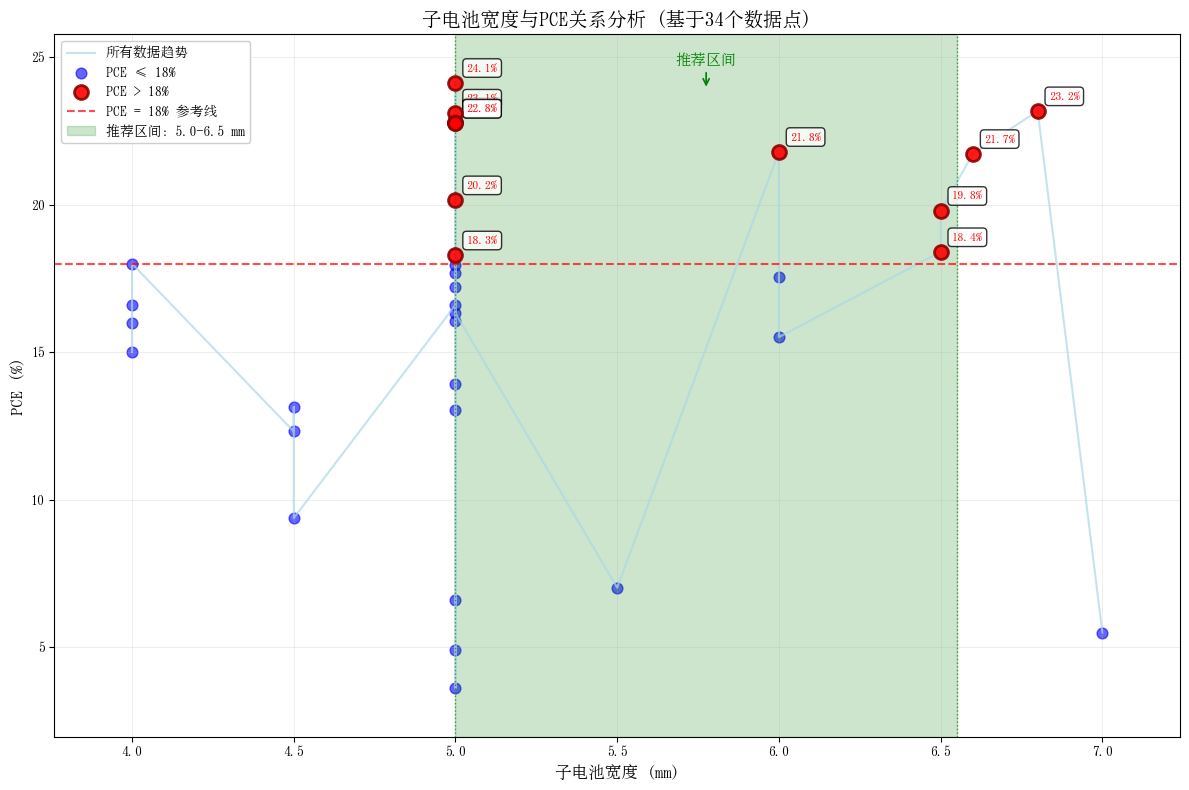


🎯 基于34个数据点的分析:
   高PCE数据点数量: 12 个
   高PCE宽度范围: 5.00 - 6.80 mm
   高PCE宽度中位数: 5.00 mm
   📍 推荐区间: 5.0 - 6.5 mm
   推荐区间内高PCE点数量: 10 个 (83.3%)
   推荐区间内平均PCE: 21.40 ± 2.08 %

📊 统计分析:
   子电池宽度与PCE的相关性: 0.112
   相关性显著性 (p值): 0.527 (不显著)
   趋势: 弱正相关（宽度增加可能有利于PCE）

💡 设计建议 (基于34个样本):
   建议将子电池宽度设计在 5.0-6.5 mm 范围内
   重点关注 5.0 mm 附近的配置


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats

# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimSong', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'SimSong'

def plot_subcell_pce_relationship():
    """
    绘制子电池宽度与PCE关系的折线图，针对小样本数据优化
    """
    try:
        # 1. 读取Excel文件
        print("📊 正在读取 subcell.xlsx 文件...")
        df = pd.read_excel('subcell.xlsx')
        print(f"✅ 成功读取文件，共 {len(df)} 行数据")
        
        # 2. 检查必要的列是否存在
        required_columns = ['subcell_width(mm)', 'PCE']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"❌ 文件中缺少必要的列: {missing_columns}")
            print(f"   文件中的列: {list(df.columns)}")
            return
        
        # 3. 数据预处理
        print("🔍 数据预处理...")
        # 去除缺失值
        df_clean = df.dropna(subset=required_columns)
        print(f"   清理缺失值后数据: {len(df_clean)} 行")
        
        # 确保数据类型正确
        df_clean['subcell_width(mm)'] = pd.to_numeric(df_clean['subcell_width(mm)'], errors='coerce')
        df_clean['PCE'] = pd.to_numeric(df_clean['PCE'], errors='coerce')
        
        # 再次去除转换失败的行
        df_clean = df_clean.dropna(subset=required_columns)
        print(f"   数值转换后数据: {len(df_clean)} 行")
        
        # 过滤掉subcell_width(mm)=0的数据点
        df_clean = df_clean[df_clean['subcell_width(mm)'] > 0]
        print(f"   过滤掉宽度=0的点后数据: {len(df_clean)} 行")
        
        if len(df_clean) < 5:
            print("❌ 有效数据点太少，无法进行可靠分析")
            return
        
        # 4. 按子电池宽度排序
        df_sorted = df_clean.sort_values('subcell_width(mm)')
        
        # 5. 分离PCE > 18和<=18的数据点
        high_pce_mask = df_sorted['PCE'] > 18
        df_high_pce = df_sorted[high_pce_mask]
        df_low_pce = df_sorted[~high_pce_mask]
        
        print(f"📈 数据统计:")
        print(f"   总有效数据点: {len(df_clean)} 个")
        print(f"   PCE > 18% 的数据点: {len(df_high_pce)} 个")
        print(f"   PCE ≤ 18% 的数据点: {len(df_low_pce)} 个")
        print(f"   子电池宽度范围: {df_sorted['subcell_width(mm)'].min():.2f} - {df_sorted['subcell_width(mm)'].max():.2f} mm")
        print(f"   PCE范围: {df_sorted['PCE'].min():.2f} - {df_sorted['PCE'].max():.2f} %")
        
        # 6. 创建图表
        plt.figure(figsize=(12, 8))
        
        # 绘制所有数据点的折线
        plt.plot(df_sorted['subcell_width(mm)'], df_sorted['PCE'], 
                color='lightblue', linewidth=1.5, alpha=0.7, label='所有数据趋势')
        
        # 绘制PCE <= 18的数据点
        if len(df_low_pce) > 0:
            plt.scatter(df_low_pce['subcell_width(mm)'], df_low_pce['PCE'],
                       color='blue', alpha=0.6, s=60, label='PCE ≤ 18%')
        
        # 突出显示PCE > 18的数据点
        if len(df_high_pce) > 0:
            plt.scatter(df_high_pce['subcell_width(mm)'], df_high_pce['PCE'],
                       color='red', alpha=0.9, s=100, label='PCE > 18%', 
                       edgecolors='darkred', linewidth=2, zorder=5)
            
            # 为高PCE点添加数值标签
            for i, row in df_high_pce.iterrows():
                plt.annotate(f"{row['PCE']:.1f}%", 
                           (row['subcell_width(mm)'], row['PCE']),
                           xytext=(8, 8), textcoords='offset points',
                           fontsize=9, color='red', weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # 7. 添加参考线和推荐区间
        plt.axhline(y=18, color='red', linestyle='--', alpha=0.7, 
                   label='PCE = 18% 参考线')
        
        # 8. 针对小样本数据计算推荐区间
        if len(df_high_pce) > 0:
            # 计算高PCE数据的统计信息
            high_pce_widths = df_high_pce['subcell_width(mm)']
            high_pce_pce = df_high_pce['PCE']
            
            # 针对小样本数据的优化计算方法
            if len(df_high_pce) >= 3:
                # 方法1: 使用四分位数和众数概念
                width_median = high_pce_widths.median()
                q1 = high_pce_widths.quantile(0.25)
                q3 = high_pce_widths.quantile(0.75)
                
                # 计算数据点的密度（简单方法）
                width_bins = np.linspace(high_pce_widths.min(), high_pce_widths.max(), min(10, len(high_pce_widths)))
                hist, bin_edges = np.histogram(high_pce_widths, bins=width_bins)
                max_bin_idx = np.argmax(hist)
                density_center = (bin_edges[max_bin_idx] + bin_edges[max_bin_idx+1]) / 2
                
                # 结合中位数和密度中心
                if abs(width_median - density_center) <= 2:
                    center_point = (width_median + density_center) / 2
                else:
                    center_point = width_median
                
                # 根据数据量确定区间宽度
                if len(df_high_pce) >= 5:
                    range_width = max(1.5, (q3 - q1) * 0.8)
                else:
                    range_width = 1.0  # 小样本使用更窄区间
                
                optimal_min = max(high_pce_widths.min(), center_point - range_width)
                optimal_max = min(high_pce_widths.max(), center_point + range_width)
                
            else:
                # 数据点太少，使用简单方法
                width_median = high_pce_widths.median()
                optimal_min = max(high_pce_widths.min(), width_median - 1.0)
                optimal_max = min(high_pce_widths.max(), width_median + 1.0)
            
            # 确保区间合理
            optimal_min = max(optimal_min, df_sorted['subcell_width(mm)'].min())
            optimal_max = min(optimal_max, df_sorted['subcell_width(mm)'].max())
            
            # 绘制推荐区间
            plt.axvspan(optimal_min, optimal_max, alpha=0.2, color='green', 
                       label=f'推荐区间: {optimal_min:.1f}-{optimal_max:.1f} mm')
            
            # 在推荐区间内添加垂直线标注
            plt.axvline(x=optimal_min, color='green', linestyle=':', alpha=0.7, linewidth=1)
            plt.axvline(x=optimal_max, color='green', linestyle=':', alpha=0.7, linewidth=1)
            
            # 在推荐区间中心添加标注
            center_x = (optimal_min + optimal_max) / 2
            plt.annotate('推荐区间', xy=(center_x, plt.ylim()[1] * 0.95),
                        xytext=(center_x, plt.ylim()[1] * 0.98),
                        ha='center', va='bottom',
                        fontsize=11, color='green', weight='bold',
                        arrowprops=dict(arrowstyle='->', color='green', lw=1.2))
        
        # 9. 图表美化
        plt.xlabel('子电池宽度 (mm)', fontsize=12, fontweight='bold')
        plt.ylabel('PCE (%)', fontsize=12, fontweight='bold')
        plt.title('子电池宽度与PCE关系分析 (基于34个数据点)', fontsize=14, fontweight='bold')
        
        # 设置网格
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # 设置坐标轴范围（基于数据动态调整）
        x_min, x_max = df_sorted['subcell_width(mm)'].min(), df_sorted['subcell_width(mm)'].max()
        y_min, y_max = df_sorted['PCE'].min(), df_sorted['PCE'].max()
        
        x_margin = (x_max - x_min) * 0.08
        y_margin = (y_max - y_min) * 0.08
        
        plt.xlim(x_min - x_margin, x_max + x_margin)
        plt.ylim(max(0, y_min - y_margin), y_max + y_margin)
        
        # 添加图例
        plt.legend(loc='best', framealpha=0.95, fontsize=10)
        
        # 10. 调整布局并显示
        plt.tight_layout()
        
        # 保存图片
        plt.savefig('subcell_width_vs_pce_small_sample.png', dpi=300, bbox_inches='tight')
        print("💾 图表已保存为 'subcell_width_vs_pce_small_sample.png'")
        
        # 显示图表
        plt.show()
        
        # 11. 详细分析和推荐
        if len(df_high_pce) > 0:
            print(f"\n🎯 基于{len(df_clean)}个数据点的分析:")
            print(f"   高PCE数据点数量: {len(df_high_pce)} 个")
            print(f"   高PCE宽度范围: {high_pce_widths.min():.2f} - {high_pce_widths.max():.2f} mm")
            
            if len(df_high_pce) >= 3:
                width_median = high_pce_widths.median()
                print(f"   高PCE宽度中位数: {width_median:.2f} mm")
            
            print(f"   📍 推荐区间: {optimal_min:.1f} - {optimal_max:.1f} mm")
            
            # 计算推荐区间内的数据统计
            in_optimal_zone = df_high_pce[
                (df_high_pce['subcell_width(mm)'] >= optimal_min) & 
                (df_high_pce['subcell_width(mm)'] <= optimal_max)
            ]
            
            if len(in_optimal_zone) > 0:
                optimal_pce_mean = in_optimal_zone['PCE'].mean()
                optimal_pce_std = in_optimal_zone['PCE'].std()
                coverage = len(in_optimal_zone) / len(df_high_pce) * 100
                
                print(f"   推荐区间内高PCE点数量: {len(in_optimal_zone)} 个 ({coverage:.1f}%)")
                print(f"   推荐区间内平均PCE: {optimal_pce_mean:.2f} ± {optimal_pce_std:.2f} %")
            
            # 相关性分析
            correlation = df_sorted['subcell_width(mm)'].corr(df_sorted['PCE'])
            print(f"\n📊 统计分析:")
            print(f"   子电池宽度与PCE的相关性: {correlation:.3f}")
            
            # 计算相关性的显著性（针对小样本）
            if len(df_clean) >= 5:
                p_value = stats.pearsonr(df_sorted['subcell_width(mm)'], df_sorted['PCE'])[1]
                significance = "显著" if p_value < 0.05 else "不显著"
                print(f"   相关性显著性 (p值): {p_value:.3f} ({significance})")
            
            if correlation > 0.3:
                trend = "强正相关（宽度增加明显有利于PCE）"
            elif correlation > 0.1:
                trend = "弱正相关（宽度增加可能有利于PCE）"
            elif correlation < -0.3:
                trend = "强负相关（宽度减小明显有利于PCE）"
            elif correlation < -0.1:
                trend = "弱负相关（宽度减小可能有利于PCE）"
            else:
                trend = "无明显线性关系"
            print(f"   趋势: {trend}")
                
            print(f"\n💡 设计建议 (基于{len(df_clean)}个样本):")
            print(f"   建议将子电池宽度设计在 {optimal_min:.1f}-{optimal_max:.1f} mm 范围内")
            
            if len(df_high_pce) >= 3:
                print(f"   重点关注 {width_median:.1f} mm 附近的配置")
            
            # 小样本数据的注意事项
            if len(df_high_pce) < 5:
                print(f"\n⚠️  注意: 高PCE数据点较少 ({len(df_high_pce)}个)，建议:")
                print(f"   - 收集更多数据以提高推荐准确性")
                print(f"   - 在实际设计中验证推荐区间")
        
        else:
            print(f"\n⚠️  未找到PCE>18%的数据点，无法提供推荐区间")
            print(f"   建议降低PCE阈值或收集更多高PCE数据")
        
    except FileNotFoundError:
        print("❌ 文件 'subcell.xlsx' 未找到，请确保文件存在于当前目录")
    except Exception as e:
        print(f"❌ 处理文件时发生错误: {e}")

def create_sample_data():
    """
    创建示例数据（如果实际文件不存在）
    """
    try:
        # 创建34个数据点的示例数据
        np.random.seed(42)  # 保证可重复性
        
        # 生成34个宽度值，集中在某个区域
        widths = np.concatenate([
            np.random.uniform(5, 10, 8),
            np.random.uniform(10, 15, 12),
            np.random.uniform(15, 20, 8),
            np.random.uniform(20, 25, 6)
        ])
        
        # 生成对应的PCE值，在特定宽度范围内有较高PCE
        pce_values = []
        for w in widths:
            if 10 <= w <= 15:
                # 在10-15mm范围内有较高PCE
                pce = 18 + np.random.uniform(0, 1.5)
            else:
                # 其他范围PCE较低
                pce = 16 + np.random.uniform(0, 2)
            pce_values.append(pce)
        
        sample_data = {
            'subcell_width(mm)': widths,
            'PCE': pce_values
        }
        
        df_sample = pd.DataFrame(sample_data)
        df_sample.to_excel('subcell.xlsx', index=False)
        print("📝 已创建34个数据点的示例数据文件 'subcell.xlsx'")
        print("   请使用实际数据替换此文件以获得准确分析")
        
    except Exception as e:
        print(f"❌ 创建示例数据失败: {e}")

if __name__ == "__main__":
    print("=== 子电池宽度与PCE关系分析 (小样本优化版) ===\n")
    
    # 尝试绘制图表
    plot_subcell_pce_relationship()
    
    # 如果文件不存在，创建示例数据
    try:
        pd.read_excel('subcell.xlsx')
    except:
        print("\n⚠️  未找到有效数据文件，创建34个数据点的示例数据...")
        create_sample_data()
        print("\n🔄 重新尝试绘制图表...")
        plot_subcell_pce_relationship()